In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dropout
from keras.layers import Dense
from keras.regularizers import l2
from keras.regularizers import l1
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def build():
    network = keras.models.Sequential()
    network.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l1(1.e-2)))
    network.add(Dense(24, activation='sigmoid', kernel_regularizer=l2(1.e-2)))
    network.add(Dense(1, activation = 'sigmoid'))
    network.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    return network

#Data preparation for regression NFL
def data_prep(data):
    data = pd.get_dummies(data)
    y = data['FirstDown']
    x = data.drop(columns = ['FirstDown'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    cols = ['YardLine', 'Distance', 'DefendersInTheBox']
    for x in cols:
        maxx = x_train[x].max(axis=0)
        minn = x_train[x].min(axis=0)
        x_train[x] -= minn
        x_train[x] /= (maxx - minn)
        x_test[x] -= minn
        x_test[x] /= (maxx - minn)
        
    return x_train, x_test, y_train, y_test

#Regression k-cross-validation
def cross_valid_reg(k, num_epochs, x_train, y_train, x_test, y_test):
    samples = len(x_train) // k
    val_history = []
    train_history = []
    for i in range(k):
        data = x_train[i * samples: (i + 1) * samples]
        targets = y_train[i * samples: (i + 1) * samples]
        partial_train_data = np.concatenate([x_train[:i * samples], x_train[(i + 1) * samples:]],axis=0)
        partial_train_targets = np.concatenate([y_train[:i * samples],y_train[(i + 1) * samples:]],axis=0)
        model = build()
        if i == 0:
            print('Input size: ', x_train.shape)
            print(model.summary())
        hist = model.fit(partial_train_data, partial_train_targets, validation_data=(data, targets),
                         epochs=num_epochs, batch_size=100, verbose=0)
        loss_history1 = hist.history['val_loss']
        loss_history2 = hist.history['loss']
        val_history.append(loss_history1)
        train_history.append(loss_history2)
        
    val_history = [np.mean([x[i] for x in val_history]) for i in range(num_epochs)]
    train_history = [np.mean([x[i] for x in train_history]) for i in range(num_epochs)]
    plt.figure(figsize=(12, 8))
    plt.rcParams.update({'font.size': 24})
    plt.plot(range(1, len(val_history) + 1), val_history)
    plt.plot(range(1, len(train_history) + 1), train_history)
    plt.xlabel('Epochs')
    plt.ylabel('loss_function')
    plt.legend(['Validation', 'Training'])
    plt.savefig('ProbNew.png')
    plt.show()
    _,mae = model.evaluate(x_test, y_test)
    print('Accuracy of the network is ', mae)
    with open('ProbNew.txt', 'w') as outfile:
        for x in range(len(val_history)):
            print(x, ' ', val_history[x], ' ', train_history[x], file=outfile)
    
    return model

In [2]:
data = pd.read_csv("data\\NFLwFormation.csv")
data['FirstDown'] = 20
data['FirstDown'] = data['FirstDown'].where(data['Distance'] <= data['Yards'], 0)
data['FirstDown'] = data['FirstDown'].mask(data['Distance'] <= data['Yards'], 1)

data = data.drop(columns = ['Yards']).dropna()

In [101]:
x_train, x_test, y_train, y_test = data_prep(data)
training_set = pd.concat([x_train, y_train], axis=1)
fd = training_set[training_set.FirstDown == 1]
not_fd = training_set[training_set.FirstDown == 0]

undersample = resample(not_fd,  
                       n_samples=len(fd),
                       random_state=0)

undersample_train = pd.concat([fd, undersample])
undersample_train.FirstDown.value_counts(normalize=True)
y_train = undersample_train['FirstDown']
x_train = undersample_train.drop(columns = ['FirstDown'])

Input size:  (10474, 117)
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_258 (Dense)            (None, 128)               15104     
_________________________________________________________________
dense_259 (Dense)            (None, 24)                3096      
_________________________________________________________________
dense_260 (Dense)            (None, 1)                 25        
Total params: 18,225
Trainable params: 18,225
Non-trainable params: 0
_________________________________________________________________
None


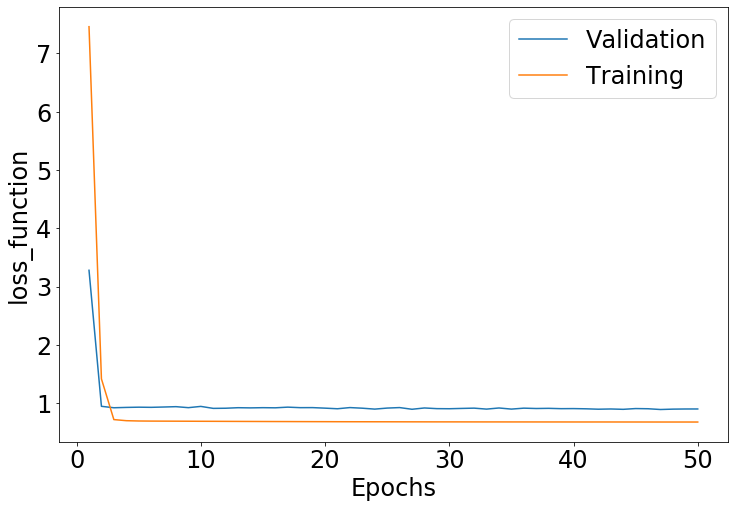

194/194 [==============================] - 0s 1ms/step - loss: 0.7937 - accuracy: 0.6467
Accuracy of the network is  0.646669864654541


In [102]:
model = cross_valid_reg(6, 50, x_train, y_train, x_test, y_test)

In [43]:
print(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

1    0.5
0    0.5
Name: FirstDown, dtype: float64 0    0.792937
1    0.207063
Name: FirstDown, dtype: float64


In [78]:
probs = []
for x in model.predict_classes(x_test).tolist():
    probs.append(x[0])

FD = y_test.tolist()
print('How many First Downs did the network predict:', len([i for i in probs if i == 1])/len(probs))

How many First Downs did the network predict: 0.29753265602322204


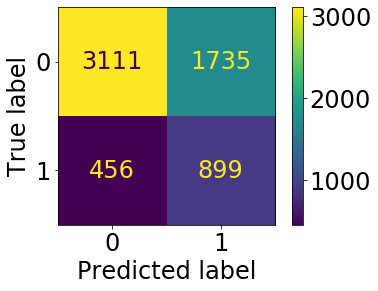

In [104]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, model.predict_classes(x_test).tolist()))
disp.plot()
plt.savefig('ProbNewConf2.png')

C:\Users\filip\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


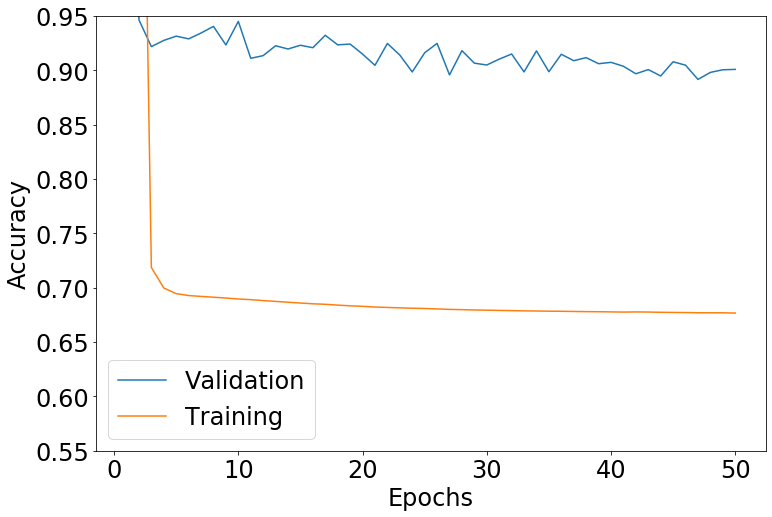

In [103]:
plot = pd.read_csv('ProbNew.txt', header = None, sep = '  ', names = ['Epochs', 'Validation', 'Training'])
plot = plot.set_index(['Epochs'])

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 24})
plt.plot(range(1, len(plot['Validation']) + 1), plot['Validation'])
plt.plot(range(1, len(plot['Training']) + 1), plot['Training'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Validation', 'Training'])
plt.ylim([0.55, 0.95])
plt.savefig('ProbNew2.png')
plt.show()

In [87]:
    network = keras.models.Sequential()
    network.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l1(1.e-4)))
    network.add(Dense(24, activation='sigmoid', kernel_regularizer=l2(1.e-3)))
    network.add(Dense(1, activation = 'sigmoid'))
    network.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

    x_train, x_test, y_train, y_test = data_prep(data)
    training_set = pd.concat([x_train, y_train], axis=1)
    fd = training_set[training_set.FirstDown == 1]
    not_fd = training_set[training_set.FirstDown == 0]

    undersample = resample(not_fd,
                       n_samples=len(fd),
                       random_state=0)

    undersample_train = pd.concat([fd, undersample])
    undersample_train.FirstDown.value_counts(normalize=True)
    y_train = undersample_train['FirstDown']
    x_train = undersample_train.drop(columns = ['FirstDown'])
    
    network.fit(x_train, y_train, epochs = 200, verbose = 0)
    network.evaluate(x_test, y_test)

194/194 [==============================] - 0s 1ms/step - loss: 0.5821 - accuracy: 0.7728


[0.582065761089325, 0.7727785706520081]

194/194 [==============================] - 0s 1ms/step - loss: 0.5821 - accuracy: 0.7728


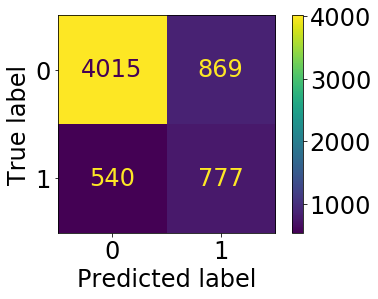

In [88]:
model = network
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, model.predict_classes(x_test).tolist()))
model.evaluate(x_test, y_test)
disp.plot()
plt.savefig('ProbNewConf1.png')